In [1]:
# Mounting of Google Drive to access the datasets

from google.colab import drive
drive.mount('/content/drive') 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
pip install pandas==1.0.5 pyarrow nltk iteration_utilities textblob

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import nltk as nltk
import pyarrow
import bz2
import json
import datetime
from iteration_utilities import deepflatten
import nltk as nltk
import scipy.stats as stats
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
pd.options.mode.chained_assignment = None
from textblob import TextBlob
sns.set_theme(context='notebook', style='white')
plt.tight_layout()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marcus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<Figure size 432x288 with 0 Axes>

In [4]:
import sys
import os

py_file_location = "/content/drive/My Drive"
sys.path.append(os.path.abspath(py_file_location))

from helpers import add_time, week, weekday_number, weekday, month, add_dict, to_dict, get_media, find_media

In [3]:
from helpers import add_time, week, weekday_number, weekday, month, add_dict, to_dict, get_media, find_media

In [4]:
# Local
project_path = '/Users/Marcus/Documents/Github/ada-project-2021-gutta-boys/'
data_path = '/Users/Marcus/Downloads/'
files = ['quotes-2015.json.bz2', 'quotes-2016.json.bz2', 'quotes-2017.json.bz2', 'quotes-2018.json.bz2', 'quotes-2019.json.bz2', 'quotes-2020.json.bz2']
path_to_wikidata_file = data_path + 'wikidata.csv'
path_to_quotebank = data_path + 'Quotebank/'


In [7]:
# Drive
path_to_file = '/content/drive/MyDrive/Quotebank/'

files_pre_cleaning = ['quotes-2017.json.bz2']

files_cleaned = ['clean-quotes-2015.csv.bz2','clean-quotes-2016.csv.bz2','clean-quotes-2017.csv.bz2',
                  'clean-quotes-2018.csv.bz2','clean-quotes-2019.csv.bz2','clean-quotes-2020.csv.bz2']

path_to_wikidata_file = '/content/drive/MyDrive/Project datasets/speaker_attributes.parquet'

In [8]:
data_path = path_to_file
files = files_pre_cleaning

In [6]:
# Reading the Wikidata files
read_wikidata_parquet = pd.read_csv(data_path + 'wikidata.csv')


In [ ]:
def find_alias_in_wiki(alias):
  ''' Returning a dataframe, consisting of one row, with Wikidata information about the given alias .
  
  Parameters
  ----------
  alias: str
    A given alias to look up in the Wikidata files
    
  Returns
  -------
  match: dataframe
    A dataframe containing information about the given alias.
  '''
  
  index = []
  for i, aliases in enumerate(read_wikidata_parquet['aliases']):
    if aliases is None:
      continue
    if alias in aliases:
        index.append(i)
  
  match = read_wikidata_parquet.loc[index]
  return match


In [ ]:
def dataset_filtered_on_aliases(aliases, dataset):
  '''Returning a filtered dataframe containing rows where 'speaker' is present in aliases array.
  
  Parameters
  ----------
  aliases: array
    An array containing desired aliases to filter on.
    
  dataset: dataframe
    The dataframe to filter.
    
  Returns
  -------
  dataset_alias_filtered: dataframe
    The given dataset filtered as described.
  '''
  
  dataset_alias_filtered = dataset[dataset['speaker'].isin(aliases)]
  # Replacing speakers of None with NaN values
  dataset_alias_filtered['speaker'] = dataset_alias_filtered['speaker'].replace('None', np.nan)
  # Dropping NaN values
  dataset_alias_filtered = dataset_alias_filtered.dropna(axis=0, subset=['speaker'])
  return dataset_alias_filtered

def get_politician_aliases(wikidata):
  wikidata['politician'] = wikidata['occupation'].apply(lambda x: isPolitician(x))
  wikidata_politician_filtered = wikidata[wikidata.politician]
  
  # After filtering on occupation, turns all aliases into 1D list
  all_wiki_aliases_politician_filtered = wikidata_politician_filtered['aliases'].tolist()
  all_wiki_aliases_politician_filtered = list(deepflatten(all_wiki_aliases_politician_filtered, depth=1))
  return all_wiki_aliases_politician_filtered

def dataset_filtered_on_politicians(wikidata, dataset):
  ''' Returning a filtered dataframe only containing quotes by politicians. 
  Note that a person can be listed with many professions and therefore distringuishing
  someone who is a former politican can be difficult.

  Parameters
  ----------
  wikidata: dataframe
    A dataframe containing the Wikidata dataset.

  dataset: dataframe
    A dataframe to filter on politicians.

  Returns
  -------
  dataset_filtered_on_politicans: dataframe
    A dataframe filtered as described.
  '''

  wikidata['politician'] = wikidata['occupation'].apply(lambda x: isPolitician(x))
  wikidata_politician_filtered = wikidata[wikidata.politician]
  
  # After filtering on occupation, turns all aliases into 1D list
  all_wiki_aliases_politician_filtered = wikidata_politician_filtered['aliases'].tolist()
  all_wiki_aliases_politician_filtered = list(deepflatten(all_wiki_aliases_politician_filtered, depth=1))

  # Returns original dataset filtered on the speakers corresponding to politicians
  dataset_filtered_on_politicans = dataset_filtered_on_aliases(all_wiki_aliases_politician_filtered, dataset)
  return dataset_filtered_on_politicans


def conv_to_string(x):
  ''' Converting the first element of a list x to a string. 
  If the input not is a list, it returns 'N/A.

  Parameters
  ----------
  x: array
    An array where we want to convert the first element into a string.

  Returns
  -------
  first_elem: str
    The first element of the array converted into a string or 'N/A' if the input is not a list.
  '''

  try:
    first_elem = str(x[0])
    return first_elem
  except:
    return 'N/A'

def isPolitician(array):
  ''' Checking whether the QID for the politician occupation is in array.
  
  Parameters
  ----------
  array: array 
    An array to check whether the QID is in.
    
  Returns
  -------
  bool
    A boolean telling whether the QID correspond to a polication or not.'''

  try:
    # Uses harcoded QID for politician == Q82955
    if 'Q82955' in array:
      return True
    else:
      return False
  except:
    return False

def get_all_aliases_of_gender(gender, wikidata):
  if gender == 'male' or gender == 'female':
    gender_qid = 'Q6581097' if gender == 'male' else 'Q6581072'
    # Converting the gender column to string to be able to check if it equals gender_qid
    wikidata_copy = wikidata.copy()
    wikidata_copy['gender'] = wikidata_copy['gender'].apply(lambda x: conv_to_string(x))
    wikidata_gender_filtered = wikidata_copy.loc[wikidata_copy['gender'] == gender_qid]

  else:
    print("Invalid gender, the function does only consider binary genders.")
    exit()
  
  # After filtering on gender, make turn all aliases into 1D list
  all_wiki_aliases_gender_filtered = wikidata_gender_filtered['aliases'].tolist()
  all_wiki_aliases_gender_filtered = list(deepflatten(all_wiki_aliases_gender_filtered, depth=1))
  return all_wiki_aliases_gender_filtered

def dataset_filtered_on_gender_with_alias(gender, wikidata, dataset):
  ''' Filtering dataset on gender given the information in Wikidata
      Only includes a row if the speaker is not 'None'.
  Parameters
  ----------
  gender: str
    A string either 'male' or 'female'.
  
  wikidata: dataframe
    A dataframe containing the Wikidata dataset.

  dataset: dataframe
    The dataset to filter on gender.

  Returns
  -------
  dataframe
    The given dataset filtered on gender.
  '''
  
  # Returning original dataset filtered on the speakers corresponding to a gender
  return dataset_filtered_on_aliases(get_all_aliases_of_gender(gender, wikidata), dataset)

In [ ]:
# Initializing a sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()

male_aliases = get_all_aliases_of_gender('male', read_wikidata_parquet)
female_aliases = get_all_aliases_of_gender('female', read_wikidata_parquet)
politician_aliases = get_politician_aliases(read_wikidata_parquet)

In [ ]:
# Iterating through all the cleaned data sets in chunks and saving compound, polarity and subjectivity score, and media outlet
for x in range(len(files)): 
  print('Working on %d. dataset'%(x+1))
  df_reader = pd.read_json(data_path + files[x], lines=True, compression='bz2', chunksize=400000)
  a=0
  for chunk in df_reader:
    print("new chunk")
    #Adding date, month, and weekday to the df

    chunk = add_time(chunk)

    females = dataset_filtered_on_aliases(female_aliases, chunk)
    males = dataset_filtered_on_aliases(male_aliases, chunk)
    politicians = dataset_filtered_on_aliases(politician_aliases, chunk)
        
    #Calculating compound score with NLTK Vader
    females['compound'] = females['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
    males['compound'] = males['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
    politicians['compound'] = politicians['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

    #Computing polarity and subjectivity score with Text Blob
    females['polarity'] = females['quotation'].apply(lambda x: TextBlob(x).sentiment[0])
    males['polarity'] = males['quotation'].apply(lambda x: TextBlob(x).sentiment[0])
    politicians['polarity'] = politicians['quotation'].apply(lambda x: TextBlob(x).sentiment[0])
    females['subjectivity'] = females['quotation'].apply(lambda x: TextBlob(x).sentiment[1])
    males['subjectivity'] = males['quotation'].apply(lambda x: TextBlob(x).sentiment[1])
    politicians['subjectivity'] = politicians['quotation'].apply(lambda x: TextBlob(x).sentiment[1])

    # Only keeping relevant columns
    females = females[['speaker', 'date_short', 'compound', 'polarity', 'subjectivity', 'weekday', 'Month']]
    males = males[['speaker', 'date_short', 'compound', 'polarity', 'subjectivity', 'weekday', 'Month']]
    politicians = politicians[['speaker', 'date_short', 'compound', 'polarity', 'subjectivity', 'weekday', 'Month']]
    

    # Writing the chunk to a csv file
    males.to_csv(path_or_buf='males_output_%d.csv.bz2'%x, compression='bz2', mode = 'a')
    females.to_csv(path_or_buf='females_output_%d.csv.bz2'%x, compression='bz2', mode = 'a')
    politicians.to_csv(path_or_buf='politicians_output_%d.csv.bz2'%x, compression='bz2', mode = 'a')

In [263]:
# Reading all quote files into one large dataframe
all_files = [path_to_quotebank + '/fil%d.csv.bz2'%i for i in range(6)]
df = pd.concat(map(pd.read_csv, [all_files[0], all_files[1],all_files[2], all_files[3], all_files[4], all_files[5]]))

/Users/marcus/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning:

Columns (2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.



In [264]:
# Removing df headers
df = df[df['Unnamed: 0'].notna()]
df[df['Unnamed: 0'].isnull()]

,Unnamed: 0,date_short,compound,polarity,subjectivity,media_outlet,weekday,Month


In [171]:
# Read demograpich quote files into dataframe
male_df = pd.read_csv(data_path + 'analyzed/male_clean_output_all.csv.bz2')
female_df = pd.read_csv(data_path + 'analyzed/female_clean_output_all.csv.bz2')
politician_df = pd.read_csv(data_path + 'analyzed/politician_clean_output_all.csv.bz2')


/Users/marcus/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning:

Columns (4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
# Export key metrics

In [265]:
# Converting relevant columns to numeric
df['compound'] = pd.to_numeric(df.compound, errors='coerce')
df['polarity'] = pd.to_numeric(df.polarity, errors='coerce')
df['subjectivity'] = pd.to_numeric(df.subjectivity, errors='coerce')

male_df['compound'] = pd.to_numeric(male_df.compound, errors='coerce')
male_df['polarity'] = pd.to_numeric(male_df.polarity, errors='coerce')
male_df['subjectivity'] = pd.to_numeric(male_df.subjectivity, errors='coerce')

female_df['compound'] = pd.to_numeric(female_df.compound, errors='coerce')
female_df['polarity'] = pd.to_numeric(female_df.polarity, errors='coerce')
female_df['subjectivity'] = pd.to_numeric(female_df.subjectivity, errors='coerce')

politician_df['compound'] = pd.to_numeric(politician_df.compound, errors='coerce')
politician_df['polarity'] = pd.to_numeric(politician_df.polarity, errors='coerce')
politician_df['subjectivity'] = pd.to_numeric(politician_df.subjectivity, errors='coerce')

In [17]:
# Declaring key metrics
pol_com_mean = politician_df['compound'].mean()
pol_sub_mean = politician_df['subjectivity'].mean()
pol_pol_mean = politician_df['polarity'].mean()

female_com_mean = female_df['compound'].mean()
female_sub_mean = female_df['subjectivity'].mean()
female_pol_mean = female_df['polarity'].mean()

male_com_mean = male_df['compound'].mean()
male_sub_mean = male_df['subjectivity'].mean()
male_pol_mean = male_df['polarity'].mean()

df_com_mean = df['compound'].mean()
df_sub_mean = df['subjectivity'].mean()
df_pol_mean = df['polarity'].mean()

com_mean = [pol_com_mean, female_com_mean, male_com_mean, df_com_mean]
sub_mean = [pol_sub_mean, female_sub_mean, male_sub_mean, df_sub_mean]
pol_mean = [pol_pol_mean, female_pol_mean, male_pol_mean, df_pol_mean]

In [32]:
# Save key metrics as csv
compound_aggregate = {'Name': ['politician', 'female', 'male', 'all'], 'Compound': com_mean, 'Polarity': sub_mean, 'Subjectivity': pol_mean}
agg_1 = pd.DataFrame(compound_aggregate)
agg_1.to_csv(path_or_buf= data_path + 'analyzed/compound_means.csv')

In [ ]:
# Analyzing data

In [14]:
t, p = stats.ttest_ind(politician_df['compound'], df['compound'])
print("Two sided paired t-test with null hypothesis: The mean mood for politicians is the same as the mean mood for all.")
print(f"t-value: {round(t, 4)}, p-value: {round(p, 10)}")
print("H0 rejected")

Two sided paired t-test with null hypothesis: The mean mood for politicians is the same as the mean mood for all.
t-value: -132.1912, p-value: 0.0
H0 rejected


In [13]:
t, p = stats.ttest_ind(female_df['compound'], male_df['compound'])
print("Two sided paired t-test with null hypothesis: The mean mood for males is the same as the mean mood for females.")
print(f"t-value: {round(t, 4)}, p-value: {round(p, 10)}")
print("H0 rejected")

Two sided paired t-test with null hypothesis: The mean mood for males is the same as the mean mood for females.
t-value: 5.7939, p-value: 6.9e-09
H0 rejected


In [ ]:
# Resampling the data

In [5]:
# Load previously saved resamples
df = pd.read_csv('all_resampled.csv', index_col='Datetime')
female_df = pd.read_csv('female_resampled.csv', index_col='Datetime')
male_df = pd.read_csv('male_resampled.csv', index_col='Datetime')
politician_df = pd.read_csv('politician_resampled.csv', index_col='Datetime')

In [266]:
frames = [df, female_df, male_df, politician_df]

In [40]:
format = '%Y-%m-%d'
# Resamples the dataframes by averaging the numeric values on the same date
for i in range(len(frames)):
    frames[i]['Datetime'] = pd.to_datetime(frames[i]['date_short'], format=format)
    frames[i] = frames[i].set_index(pd.DatetimeIndex(frames[i]['Datetime']))
    frames[i] = frames[i][['compound','polarity','subjectivity', 'Datetime']]
    frames[i] = frames[i].resample('D', on='Datetime').mean()

In [267]:
frame_names = ['all', 'females', 'males', 'politicians']

In [45]:
x=0
for frame in frames:
    frame.to_csv('%s_resampled.csv' % frame_names[x], mode = 'a')
    x+=1


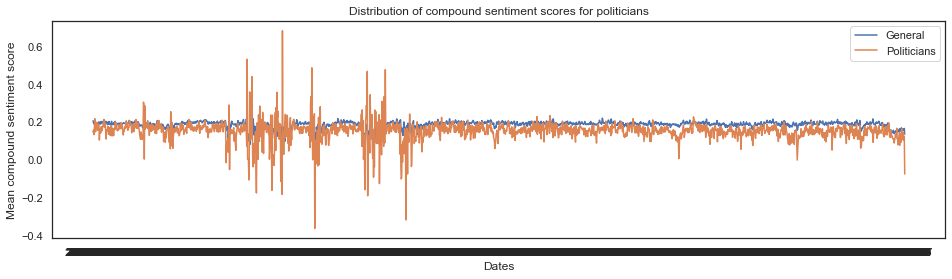

In [32]:
fig, ax = plt.subplots(1,1, figsize = (16,4))
ax.plot(frames[0].index, frames[0].compound)
ax.plot(frames[3].index, frames[3].compound)
ax.legend(['General', 'Politicians'])
ax.set_title('Distribution of compound sentiment scores for politicians') 
ax.set_xlabel('Dates')
ax.set_ylabel('Mean compound sentiment score')
ax.set_yscale('linear')
plt.show()

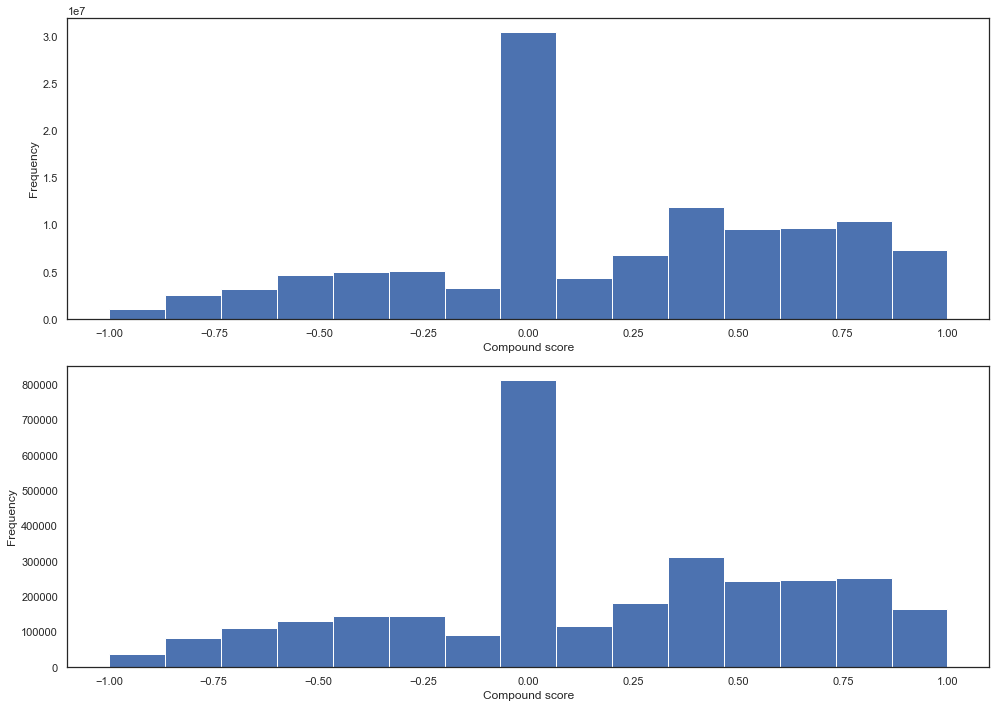

In [20]:
#Plotting the compound score distributions of all data and politicians

fig, ax = plt.subplots(2,1, figsize=(14,10))

ax[0].hist(frames[0].compound, bins=15)
ax[0].set_xlabel('Compound score')
ax[0].set_ylabel('Frequency')
ax[1].hist(frames[3].compound, bins=15)
ax[1].set_xlabel('Compound score')
ax[1].set_ylabel('Frequency')

fig.tight_layout()

plt.show()

In [268]:
import plotly.graph_objects as go


In [156]:
# Exporting data with plotly

In [153]:
# Binning the compound scores by counting the numeric values in 0.1 range
binned_compound_dfs = {}

for i in range(len(frames)):
    binned = pd.cut(frames[i]['compound'], bins=np.linspace(-1, 1, 201), include_lowest=True)
    result = binned.value_counts(sort=False).rename_axis('value_range').to_frame('count')
    binned_compound_dfs[frame_names[i]] = result
    binned_compound_dfs[frame_names[i]].index = [round((i.left+i.right)/2, 3) for i in binned_compound_dfs[frame_names[i]].index.values]


In [151]:
# Binning subjectivity scores    
binned_subjectivity_dfs = {}

for i in range(len(frames)):
    binned = pd.cut(frames[i]['subjectivity'], bins=np.linspace(0, 1, 101), include_lowest=True)
    result = binned.value_counts(sort=False).rename_axis('value_range').to_frame('count')
    binned_subjectivity_dfs[frame_names[i]] = result
    binned_subjectivity_dfs[frame_names[i]].index = [round((i.left+i.right)/2, 3) for i in binned_subjectivity_dfs[frame_names[i]].index.values]


In [276]:

def bin_df(frame, column, bin_width):
    binning_df = frame[[column]]
    # create the bins
    counts, bins = np.histogram(binning_df[column], bins=bin_width,  density=True)
    bins = 0.5 * (bins[:-1] + bins[1:])
    return {'bins': bins, 'counts': counts}


In [273]:
df_binned = bin_df(df, 'compound', 201)

In [309]:
df_binned_sub = bin_df(df, 'subjectivity', 26)

In [274]:
pd.DataFrame(df_binned).to_csv(data_path + '/analyzed/df_binned.csv') 


In [281]:
pd.DataFrame(df_binned_sub).to_csv(data_path + '/analyzed/df_binned_sub.csv') 


In [154]:
# Writing binned dataframes to csv  
for key, value in binned_compound_dfs.items():
    value.to_csv(data_path + 'analyzed/' + key + '_compound_binned.csv')


In [155]:
# Writing binned dataframes to csv  
for key, value in binned_subjectivity_dfs.items():
    value.to_csv(data_path + 'analyzed/' + key + '_subjectivity_binned.csv')


In [261]:
df = pd.read_csv(data_path + 'analyzed/' + 'all' + '_subjectivity_binned.csv', index_col='Unnamed: 0')

,Unnamed: 0,speaker,date_short,compound,polarity,subjectivity,weekday,Month


In [310]:
df_politician = politician_df[['subjectivity']]

# create the bins
counts, bins = np.histogram(df_politician.subjectivity, bins=26,  density= True)

bins = 0.5 * (bins[:-1] + bins[1:])


In [312]:

fig = go.Figure(data=[
    go.Bar(name='Politicians', x=bins, y=counts),
    go.Bar(name='All', x=df_binned_sub['bins'], y=df_binned_sub['counts'])
])

fig.update_layout(title='Subjectivity distribution')

fig.update_layout(barmode='group')


fig.write_html(data_path + 'analyzed/images/bar_dist_sub_pol_all.html', full_html=False, include_plotlyjs='cdn')

fig.show()

In [24]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df.subjectivity,
    histnorm='percent',
    name='All', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-1.0,
        end=1.0,
        size=0.1
    ),
    opacity=0.95
))
fig.add_trace(go.Histogram(
    x=politician_df.subjectivity,
    histnorm='percent',
    name='Politicians',
    xbins=dict(
        start=-1.0,
        end=1,
        size=0.1
    ),
    opacity=0.95
))

fig.update_layout(
    title_text='Compound distribution', # title of plot
    xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Frequency', # yaxis label
    bargap=0.01, # gap between bars of adjacent location coordinates
    bargroupgap=0.01 # gap between bars of the same location coordinates
)

fig.write_html(data_path + 'analyzed/images/line_subjectivity_dist_pol_df.html', full_html=False, include_plotlyjs='cdn')

fig.show()



KeyboardInterrupt: 

In [109]:
# creating line diagram for average compound score over different timeperiods for the different demographics
i = 0
timeperiod_names = ['date', 'week', 'month']

for frame in frames:
    frame.index = pd.to_datetime(frame.index)

    # Using date, week and month 
    timeperiods = [frame, frame.resample('7D').mean(), frame.resample('M').mean()]
    j = 0
    for timeperiod in timeperiods:
        title = "Mean sentiment of quotes per day for %s" % frame_names[i]
        fig = px.line(timeperiod.compound, title=title, labels={
                    'value': 'Mean sentiment',
                    'variable': 'Type',
                    'Datetime': 'Date'
                    })
        fig.update_layout(showlegend=False)
        fig.data[0].name = 'Sentiment'

        fig.write_html(data_path + 'analyzed/images/line_compound_%s_%s.html' % (frame_names[i], timeperiod_names[j]), full_html=False,
                        include_plotlyjs='cdn')
        j+=1
                       
        fig.show()
    i+=1
    

In [121]:
# Creating line diagram for average compound score over different timeperiods for the different demographics


pol_week = frames[3].resample('7D').mean()
all_week = frames[0].resample('7D').mean()

line = px.line(y=[pol_week.compound, all_week.compound], x=pol_week.index, title="Mean sentiment of quotes per day for days", category_orders={'Dates': frames[3].index}, labels={
                    'value':'Mean compound sentiment',
                    'x': 'Time',
                    'variable': 'Variables'
                    })

line.update_traces(hovertemplate="<b>Day: </b> %{wide_variable_1} <br>")
line.data[0].name="Politicians"
line.data[1].name="All"

#line.write_html(data_path + 'analyzed/images/line_compound_pol_all_week.html', full_html=False,
#                        include_plotlyjs='cdn')


line.show()

In [82]:
# Creating line diagram for average compound score over different timeperiods for the different demographics

female_week = frames[1].resample('7D').mean()
male_week = frames[2].resample('7D').mean()


line_2 = px.line(y=[male_week.compound, female_week.compound], x=male_week.index, title="Mean weekly sentiment", category_orders={'Dates': frames[3].index}, labels={
                    'value':'Mean sentiment score',
                    'x': 'Time in weeks (7 day intervals)'
                    })
line_2.data[0].name="Males"
line_2.data[1].name="Females"

line_2.write_html(data_path + 'analyzed/images/line_compound_males_females_week.html', full_html=False,
                        include_plotlyjs='cdn')


line_2.show()

In [78]:
print(female_week.compound.mean())
print(male_week.compound.mean())



0.1911143561415037
0.18876362502204408


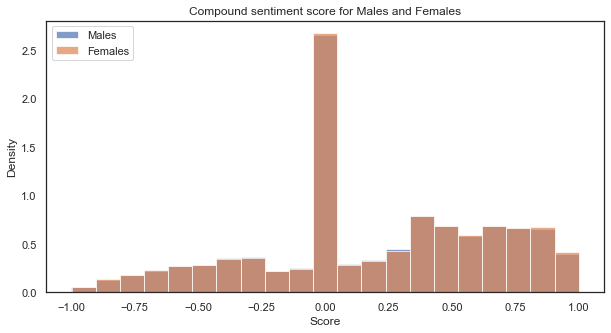

In [185]:
plt.figure(figsize=(10, 5))
plt.hist(male_df['compound'], bins=21,density=True, alpha=0.7, label='Males')
plt.hist(female_df['compound'], bins=21,density=True, alpha=0.7, label='Females')
plt.title("Compound sentiment score for Males and Females")
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

/Users/marcus/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/Users/marcus/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



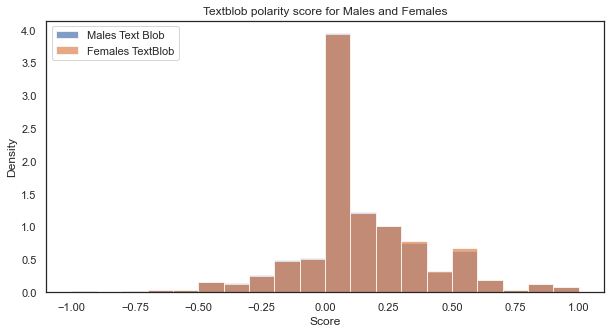

In [150]:
plt.figure(figsize=(10,5))
plt.hist(male_df['polarity'], bins=20, alpha=0.7, density=True, label='Males Text Blob')
plt.hist(female_df['polarity'], bins=20, alpha=0.7, density=True, label='Females TextBlob')
plt.title("Textblob polarity score for Males and Females")
plt.legend(loc='upper left')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()